In [3]:
import os
import random
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
ROOT = "data"
train_data = datasets.MNIST(root=ROOT, train=True, download=True)
test_data = datasets.MNIST(root=ROOT, train=False, download=True)

In [6]:
train_data.data.shape, test_data.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [8]:
# Plot image
def plot_images(images):
    n_images = len(images)
    
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    
    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(images[i], cmap="bone")
        ax.axis("off")

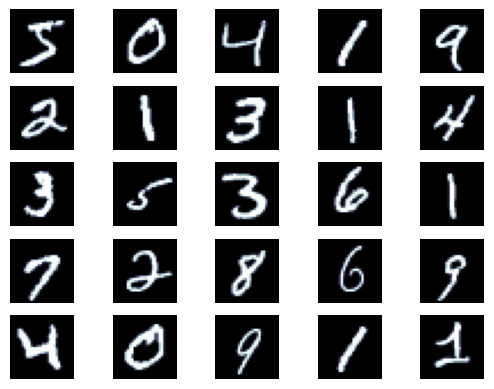

In [9]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)

## Preprocessing Data

### Split training - validation : 0.9 - 0.1

In [10]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data,
    [n_train_examples, n_valid_examples]
)

len(train_data), len(valid_data)

(54000, 6000)

### Compute mean and std for normalization

In [11]:
# Calculate mean and std using the original dataset before splitting
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

mean, std

(tensor(0.1307), tensor(0.3081))

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

# Apply transforms to the original dataset before splitting
train_data.dataset.transform = train_transforms
valid_data.transform = test_transforms
test_data.transform = test_transforms

### Create dataloader

In [13]:
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    shuffle=False,
    batch_size=BATCH_SIZE
)

test_dataloader = data.DataLoader(
    test_data, 
    shuffle=False, 
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(valid_dataloader), len(test_dataloader)

(211, 24, 40)

In [7]:
next(iter(train_dataloader))[0].shape

torch.Size([256, 1, 28, 28])

## Setup Model

In [16]:
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_samples = 0, 0
    losses = []
    start_time = time.time()
    
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(inputs)
        
        # Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())
        
        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        
        # Update metrics
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)
        
        # Log progress at intervals
        if batch_idx % log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print(
                f"| Epoch {epoch:3d} | Batch {batch_idx:5d}/{len(train_dataloader):5d} | "
                f"Accuracy {total_acc / total_samples:.3f}"
            )
            total_acc, total_samples = 0, 0
            start_time = time.time()
            
    epoch_acc = total_acc / total_samples
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

def evaluate(model, criterion, device, valid_dataloader):
    model.eval()
    total_acc, total_samples = 0, 0
    losses = []
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            predictions = model(inputs)
            
            # Compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())
            
            # Update metrics
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)
    
    epoch_acc = total_acc / total_samples
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

### LeNet

In [17]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding="same")
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)
    
    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [18]:
# Setup
num_classes = len(train_data.dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, criterion, optimizer
model  = LeNetClassifier(num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


### Training Model

In [ ]:
# Training parameters
num_epochs = 10
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_eval_loss = float("inf")

for epoch in range(1, num_epochs + 1):
    start_time  = time.time()
    
    # Train
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, device, valid_dataloader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)
    
    # Save the best model
    if eval_loss < best_eval_loss:
        torch.save(model.state_dict(), os.path.join(model_dir, "lenet_model.pth"))
    
    # Logging
    elapsed_time = time.time() - start_time
    print("=" * 59)
    print(
        f"End of Epoch {epoch:3d} | Time: {elapsed_time:.2f}s | "
        f"Train Acc: {train_acc:.3f}, Train Loss: {train_loss:.3f} | "
        f"Val Acc: {eval_acc:.3f}, Val Loss: {eval_loss:.3f}"
    )
    print("=" * 59)
    
    # Load the best model
    model.load_state_dict(torch.load(os.path.join(model_dir, "lenet_model.pth")))
    model.eval()

| Epoch   1 | Batch    50/  211 | Accuracy 0.670
| Epoch   1 | Batch   100/  211 | Accuracy 0.887
| Epoch   1 | Batch   150/  211 | Accuracy 0.918
| Epoch   1 | Batch   200/  211 | Accuracy 0.944
End of Epoch   1 | Time: 6.29s | Train Acc: 0.958, Train Loss: 0.498 | Val Acc: 0.951, Val Loss: 0.167


/tmp/ipykernel_212034/4153427581.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_dir, "lenet_model.pth")))


| Epoch   2 | Batch    50/  211 | Accuracy 0.959
| Epoch   2 | Batch   100/  211 | Accuracy 0.961
| Epoch   2 | Batch   150/  211 | Accuracy 0.968
| Epoch   2 | Batch   200/  211 | Accuracy 0.971
End of Epoch   2 | Time: 5.00s | Train Acc: 0.967, Train Loss: 0.115 | Val Acc: 0.974, Val Loss: 0.096
| Epoch   3 | Batch    50/  211 | Accuracy 0.975
| Epoch   3 | Batch   100/  211 | Accuracy 0.975
| Epoch   3 | Batch   150/  211 | Accuracy 0.978
| Epoch   3 | Batch   200/  211 | Accuracy 0.974
End of Epoch   3 | Time: 5.13s | Train Acc: 0.976, Train Loss: 0.081 | Val Acc: 0.973, Val Loss: 0.091
| Epoch   4 | Batch    50/  211 | Accuracy 0.980
| Epoch   4 | Batch   100/  211 | Accuracy 0.980
| Epoch   4 | Batch   150/  211 | Accuracy 0.978
| Epoch   4 | Batch   200/  211 | Accuracy 0.978
End of Epoch   4 | Time: 6.80s | Train Acc: 0.976, Train Loss: 0.069 | Val Acc: 0.976, Val Loss: 0.079
| Epoch   5 | Batch    50/  211 | Accuracy 0.982
| Epoch   5 | Batch   100/  211 | Accuracy 0.981
| Epo

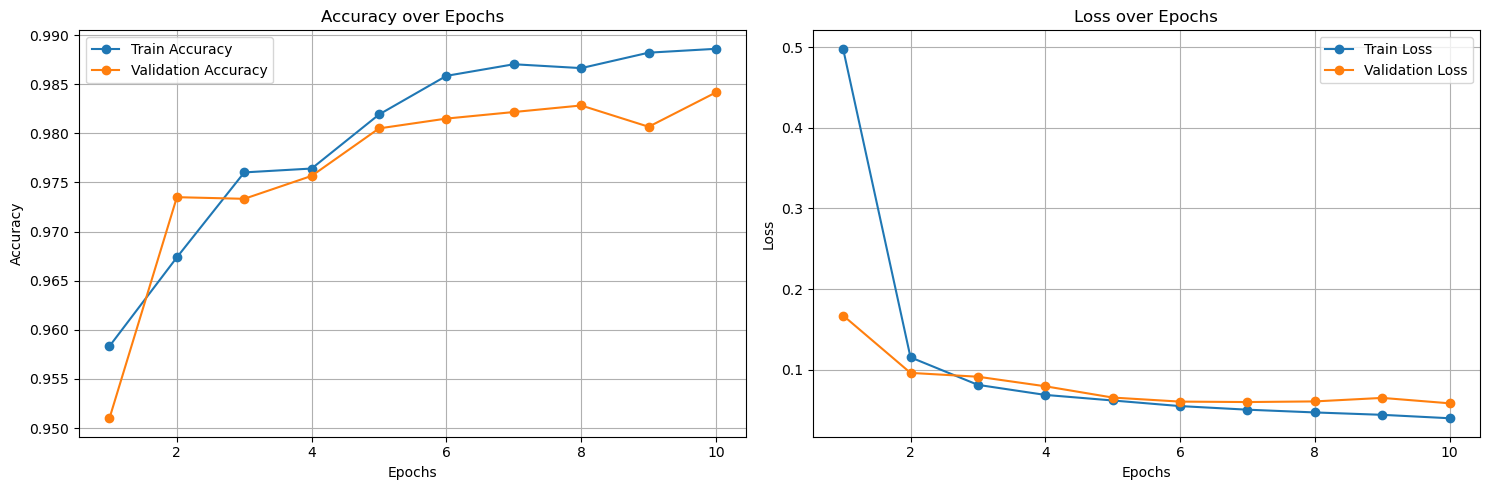

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy", marker='o')
axes[0].plot(range(1, num_epochs + 1), eval_accs, label="Validation Accuracy", marker='o')
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid()

axes[1].plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
axes[1].plot(range(1, num_epochs + 1), eval_losses, label="Validation Loss", marker='o')
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


### Evaluate model

In [22]:
test_acc, test_loss = evaluate(model, criterion, device, test_dataloader)
test_acc, test_loss

(0.9855, 0.04622236158684245)

### Inference

In [ ]:
def load_model(model_path, num_classes=10):
    model = LeNetClassifier(num_classes)
    model.load_state_dict(torch.load(model_path, weights_only=True)) # Load the weights
    model.eval() # Set the model to evaluation mode
    return model


def inference(img_path, model):
    # Load the image
    image = Image.open(img_path)
    w, h = image.size
    
    # Ensure the image is square by center cropping
    if w != h:
        crop = transforms.CenterCrop(min(w, h)) # Crop to the smallest side length
        image = crop(image)
    
    # Define the image transformation pipeline
    img_transform = transforms.Compose([
        transforms.Grayscale(), # Convert image to grayscale
        transforms.Resize(28), # Resize image to 28x28
        transforms.ToTensor(), # Convert image to a PyTorch tensor
        transforms.Normalize(mean=[0.1307], std=[0.3081]) # Normalize with mean and std
    ])
    
    # Apply the transformations
    img_new = img_transform(image)
    
    # Add batch and channel dimensions to match the model input
    img_new = img_new.expand(1, 1, 28, 28)
    
    with torch.no_grad():
        predictions = model(img_new) # Get model predictions
    
    # Apply softmax to convert logits into probabilities
    preds = nn.Softmax(dim=1)(predictions)
    
    # Get the maximum probability and corresponding class index
    p_max, y_hat = torch.max(preds.data, 1)
    return p_max.item(), y_hat.item()

In [50]:
model = load_model("./models/lenet_model.pth")
preds = inference("./data/demo_8.png", model)
preds

(0.9994237422943115, 8)

## Visualizing Filters and Images

In [ ]:
def plot_filtered_images(images, filters):
    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()
    
    n_images = images.shape[0]
    n_filters = filters.shape[0]
    
    filtered_images = F.conv2d(images, filters)
    
    fig = plt.figure(figsize=(20, 10))
    
    for i in range(n_images):
        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap="bone")
        ax.set_title("Original")
        ax.axis("off")
        
        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap="bone")
            ax.set_title(f"Filter {j+1}")
            ax.axis("off")

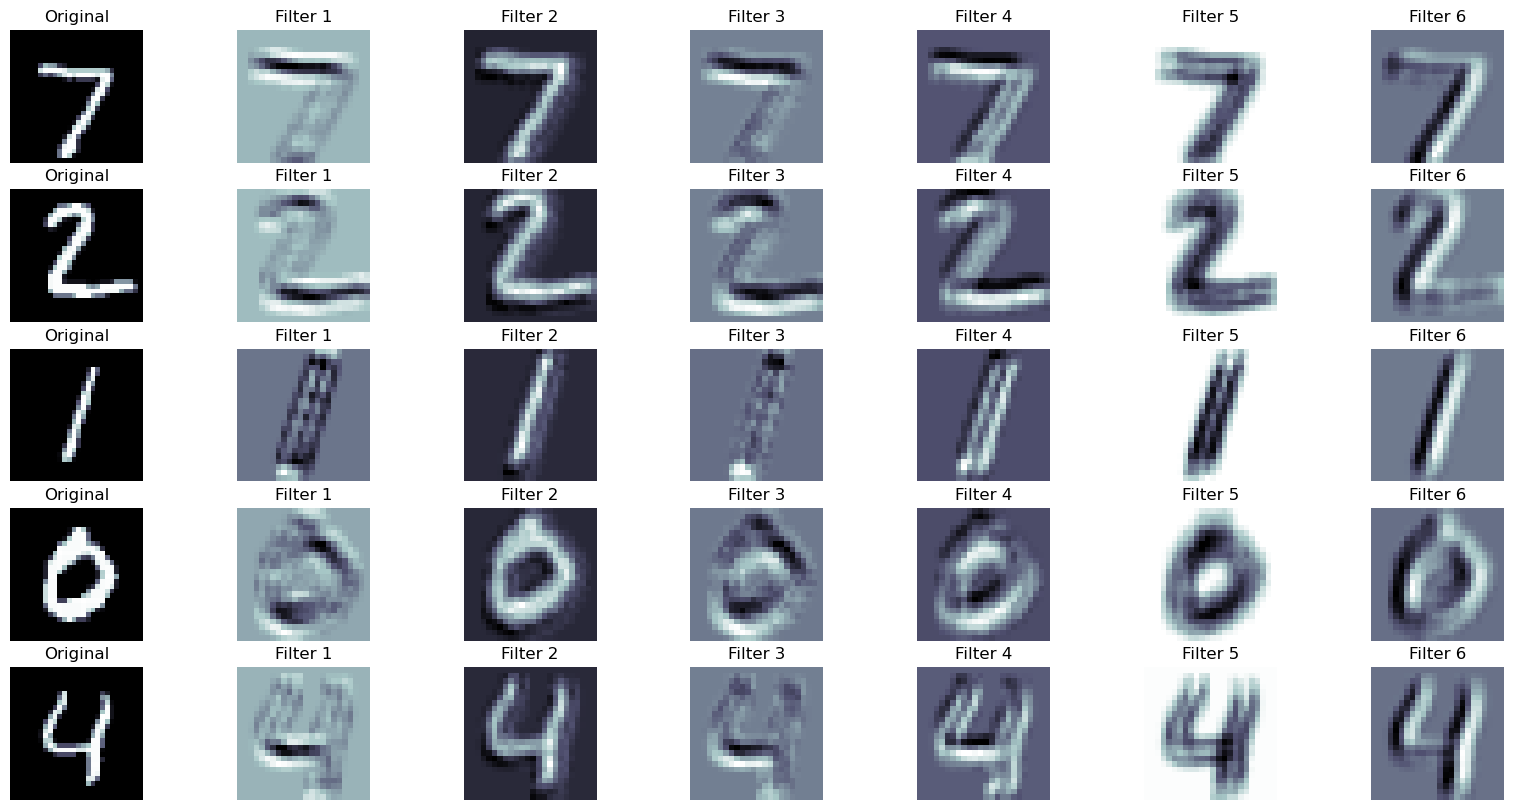

In [ ]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters)